# RynnBrain Inference Recipes

## Section 4:  Object Location
In this section, we present the ability for RynnBrain in egocentric object location.

### [Setup] Load visualization utils

In [1]:
import os
ROOT_PATH="" # set the path to root dir
assert ROOT_PATH != "", "Please set ROOT_PATH to the cookbooks directory."
os.chdir(ROOT_PATH)


import glob
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Image as IPyImage
import io
import re
import cv2
import numpy as np

def split_at_middle_space(text, first_line_ratio=0.51):
    text = text.strip()
    space_positions = [i for i, char in enumerate(text) if char == ' ']
    
    if not space_positions:  
        return text
    
    target_pos = int(len(text) * first_line_ratio)
    
    split_pos = min(space_positions, key=lambda x: abs(x - target_pos))
    
    first_line = text[:split_pos].strip()
    second_line = text[split_pos:].strip()
    
    return f"{first_line}\n{second_line}"

def add_frame_id(conversation):
  for message in conversation:
    if message["role"] == "user":
        image_idx = 0
        new_contents = []
        for i, content in enumerate(message["content"]):
            if content["type"] == "image":
                    new_contents.append({"type": "text", "text": f"<frame {image_idx}>: "})
                    image_idx += 1
            new_contents.append(content)
        message["content"] = new_contents
  return conversation


def show_images_grid(
    img_dir,
    n=8,
    cols=4,
    figsize_per_cell=(4, 4),
    exts=("png", "jpg", "jpeg", "bmp", "webp"),
    sort=True,
    show_title=True,
    keep_axis=True,
):
    patterns = [os.path.join(img_dir, f"*.{e}") for e in exts]
    paths = []
    for pat in patterns:
        paths.extend(glob.glob(pat))
    if sort:
        paths = sorted(paths)

    paths = paths[:n]
    if len(paths) == 0:
        raise FileNotFoundError(f"No images found in {img_dir} with extensions {exts}")

    rows = (len(paths) + cols - 1) // cols
    fig_w = figsize_per_cell[0] * cols
    fig_h = figsize_per_cell[1] * rows
    fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h), squeeze=False)

    for i, ax in enumerate(axes.flat):
        if i < len(paths):
            p = paths[i]
            img = Image.open(p)
            ax.imshow(img)

            if show_title:
                ax.set_title(os.path.basename(p), fontsize=10)

            if keep_axis:
                # ax.set_xlabel("x (px)")
                # ax.set_ylabel("y (px)")
                ax.tick_params(labelsize=8)
            else:
                ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

def convert_bbox_to_raw(bbox, w, h):
    bbox_norm = [max(0, min(1000, v)) for v in bbox]
    bbox_raw = [
        int(round(bbox_norm[0] / 1000 * (w-1))),
        int(round(bbox_norm[1] / 1000 * (h-1))),
        int(round(bbox_norm[2] / 1000 * (w-1))),
        int(round(bbox_norm[3] / 1000 * (h-1))),
    ]
    return bbox_raw


def draw_bbox_on_image(img, bbox, color="red", width=4, show_width=400, text=None):
    # img = Image.open(img_path).convert("RGB")
    w, h = img.size
    draw = ImageDraw.Draw(img)

    x1, y1, x2, y2 = bbox
    draw.rectangle([x1, y1, x2, y2], outline=color, width=width)

    if text:
        if isinstance(text, list):
            text = "\n".join(text)
        text = split_at_middle_space(text)
        bbox_pixels =  x2 - x1
        text_length = len(text)
        min_fontsize = 6
        max_fontsize = 40
        fontsize = max(min_fontsize, min(max_fontsize, int(bbox_pixels / max(1, text_length * 0.3))))
        font = ImageFont.truetype("assets/arial.ttf", fontsize)
        
        try:
            bbox_text = draw.textbbox((0, 0), text, font)
        except:
            bbox_text = draw.textsize(text, font)
            bbox_text = (0, 0, bbox_text[0], bbox_text[1])
        
        text_width = bbox_text[2] - bbox_text[0]
        text_height = bbox_text[3] - bbox_text[1]
        
        y_shift = 0
        padding = 5
        text_x = max(min(x1+padding, 0.8*w),padding)
        text_y = max(min(y1+y_shift+padding, 0.95*h),padding)
        
        # print(bbox_pixels, text_length, fontsize)

        background_rect = [
            text_x - padding, text_y - padding,
            text_x + text_width + padding, text_y + text_height + 3 * padding
        ]
        draw.rectangle(background_rect, fill=color)
        
        draw.text((text_x, text_y), text, fill="white", font=font)
    buf = io.BytesIO()
    img.save(buf, format="PNG")
    buf.seek(0)
    display(IPyImage(data=buf.getvalue(), width=show_width))
  

def parse_frame_id_and_bbox(output_text):
    try:
        frame_match = re.search(r'frame (\d+)', output_text)
        if frame_match:
            frame_id = int(frame_match.group(1))
            
            coord_match = re.search(r'\((\d+),\s*(\d+)\)\,\s*\((\d+),\s*(\d+)\)', output_text)
            if coord_match:
                bbox = (
                    int(coord_match.group(1)),
                    int(coord_match.group(2)),
                    int(coord_match.group(3)),
                    int(coord_match.group(4))
                )
                return frame_id, bbox
    except:
        pass
    return None, None

def parse_bbox(output_text):
    try:    
        coord_match = re.search(r'\((\d+),\s*(\d+)\)\,\s*\((\d+),\s*(\d+)\)', output_text)
        if coord_match:
            bbox = (
                int(coord_match.group(1)),
                int(coord_match.group(2)),
                int(coord_match.group(3)),
                int(coord_match.group(4))
            )
            return bbox
    except:
        pass
    return None

### [General] Load Model and Processor

In [2]:
from transformers import AutoModelForImageTextToText, AutoProcessor

model_path = "Alibaba-DAMO-Academy/RynnBrain-8B"
model = AutoModelForImageTextToText.from_pretrained(model_path, dtype="auto", device_map="auto")
processor = AutoProcessor.from_pretrained(model_path)


/usr/local/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2026-02-02 06:18:18.114787: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 06:18:18.164493: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-02 06:18:18.164518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-02 06:18:18.165741: E exte

### Video Example:

1.Load and visualize the video

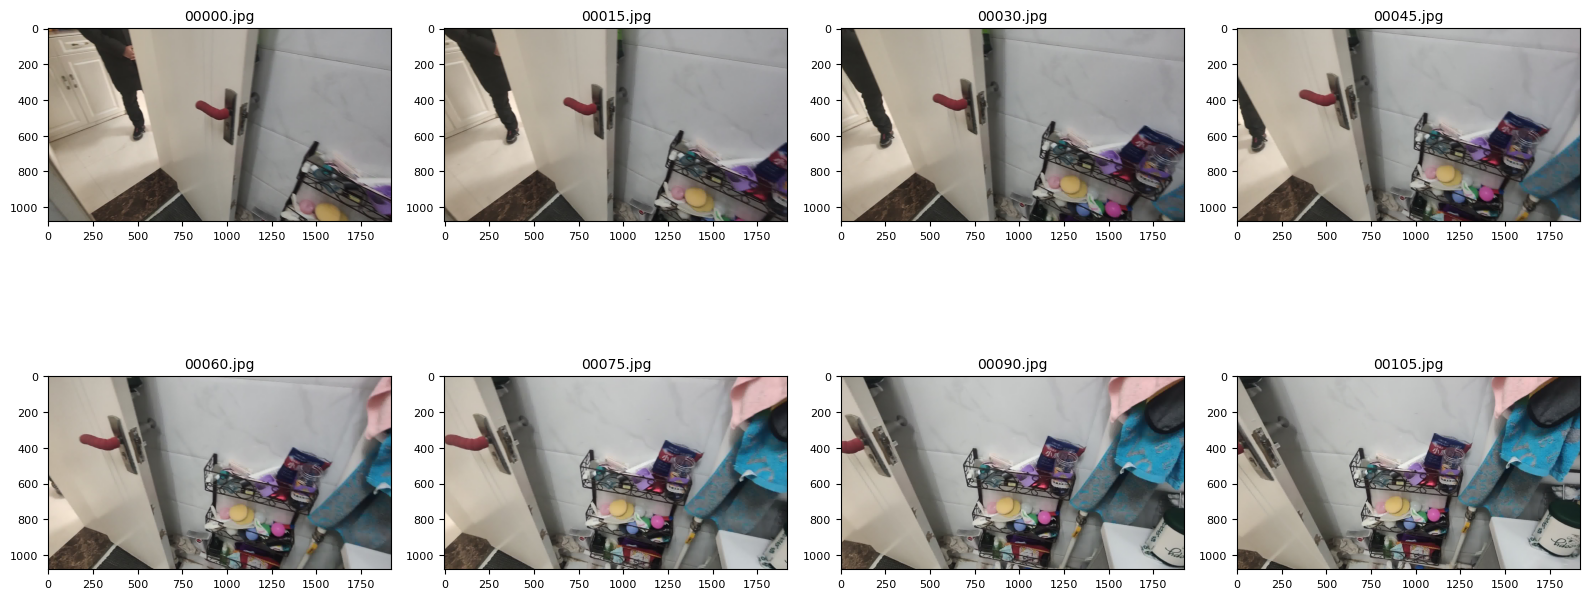

In [3]:
VIDEO_PATH="assets/object_location/videos/0"
show_images_grid(VIDEO_PATH)

2.Generate messages

In [4]:
from pathlib import Path
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

img_paths = sorted(
    [os.path.join(VIDEO_PATH, f) for f in os.listdir(VIDEO_PATH)
     if os.path.splitext(f)[1].lower() in exts]
)
content = []
for p in img_paths:
    content.append({"type": "image", "image": str(p)})

instruction = "Please detect the the blue cloth in the bathroom in this video."
format_prompt = "Output the bounding box in the format <object> <frame n>: ...; (x1,y1), (x2,y2) </object>, where x,y are in the range of (0,1000), n is the chosen frame index."
content.append({"type": "text", "text": f"{instruction}\n{format_prompt}"})

messages = [
    {
        "role": "user",
        "content": content
    }
]
messages = add_frame_id(messages)
print(messages)

[{'role': 'user', 'content': [{'type': 'text', 'text': '<frame 0>: '}, {'type': 'image', 'image': 'assets/object_location/videos/0/00000.jpg'}, {'type': 'text', 'text': '<frame 1>: '}, {'type': 'image', 'image': 'assets/object_location/videos/0/00015.jpg'}, {'type': 'text', 'text': '<frame 2>: '}, {'type': 'image', 'image': 'assets/object_location/videos/0/00030.jpg'}, {'type': 'text', 'text': '<frame 3>: '}, {'type': 'image', 'image': 'assets/object_location/videos/0/00045.jpg'}, {'type': 'text', 'text': '<frame 4>: '}, {'type': 'image', 'image': 'assets/object_location/videos/0/00060.jpg'}, {'type': 'text', 'text': '<frame 5>: '}, {'type': 'image', 'image': 'assets/object_location/videos/0/00075.jpg'}, {'type': 'text', 'text': '<frame 6>: '}, {'type': 'image', 'image': 'assets/object_location/videos/0/00090.jpg'}, {'type': 'text', 'text': '<frame 7>: '}, {'type': 'image', 'image': 'assets/object_location/videos/0/00105.jpg'}, {'type': 'text', 'text': 'Please detect the the blue cloth

3.Infer with RynnBrain

In [5]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

The object is <object>  <frame 7>:; (644, 0), (1000, 738) </object>.


4.Visualization

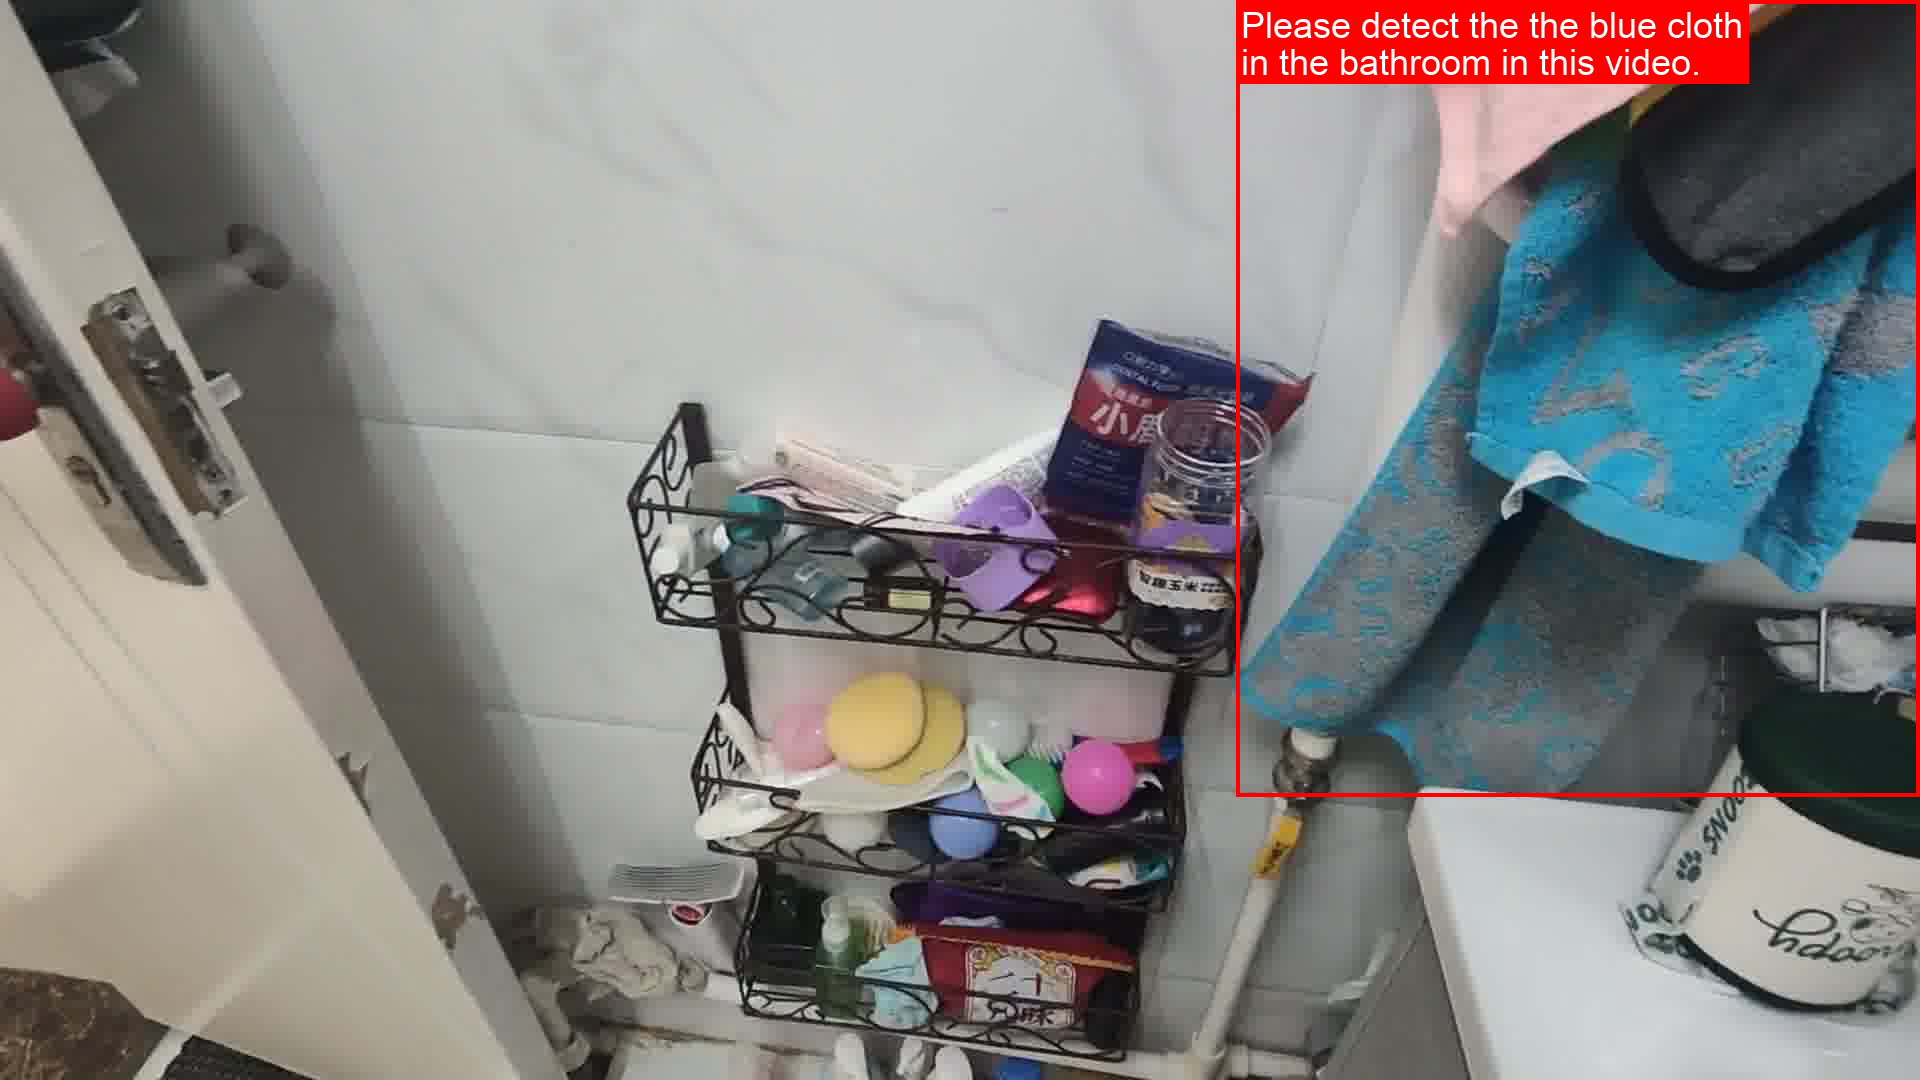

In [6]:
frame_id, bbox = parse_frame_id_and_bbox(output_text)
img_path = img_paths[frame_id]
img = Image.open(img_path).convert("RGB")
img = img.resize((int(1080*img.size[0]/img.size[1]),1080))
w, h = img.size
bbox_raw = convert_bbox_to_raw(bbox, w, h)
draw_bbox_on_image(img, bbox_raw, color="red", width=4, show_width=600, text=instruction)

### Image Example:

1.Generate messages

In [7]:
from pathlib import Path
exts = {".jpg", ".jpeg", ".png", ".bmp", ".webp"}

image_path = "assets/object_location/images/000000086408.jpg"
content = []
content.append({"type": "image", "image": image_path})

instruction = "What appliance can be used to heat food quickly."
format_prompt = "Generate coordinates for one object bounding box. Constraints: x1,y1,x2,y2 ∈ [0,1000]. Response must be in the format: <object> (x1, y1), (x2, y2) </object>"
content.append({"type": "text", "text": f"{instruction}\n{format_prompt}"})

messages = [
    {
        "role": "user",
        "content": content
    }
]
# messages = add_frame_id(messages)
print(messages)

[{'role': 'user', 'content': [{'type': 'image', 'image': 'assets/object_location/images/000000086408.jpg'}, {'type': 'text', 'text': 'What appliance can be used to heat food quickly.\nGenerate coordinates for one object bounding box. Constraints: x1,y1,x2,y2 ∈ [0,1000]. Response must be in the format: <object> (x1, y1), (x2, y2) </object>'}]}]


2.Infer with RynnBrain 

In [8]:
inputs = processor.apply_chat_template(
    messages,
    tokenize=True,
    add_generation_prompt=True,
    return_dict=True,
    return_tensors="pt"
)
inputs = inputs.to(model.device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)[0]
print(output_text)

<object> (328,47), (556,272) </object>


3.Visualization

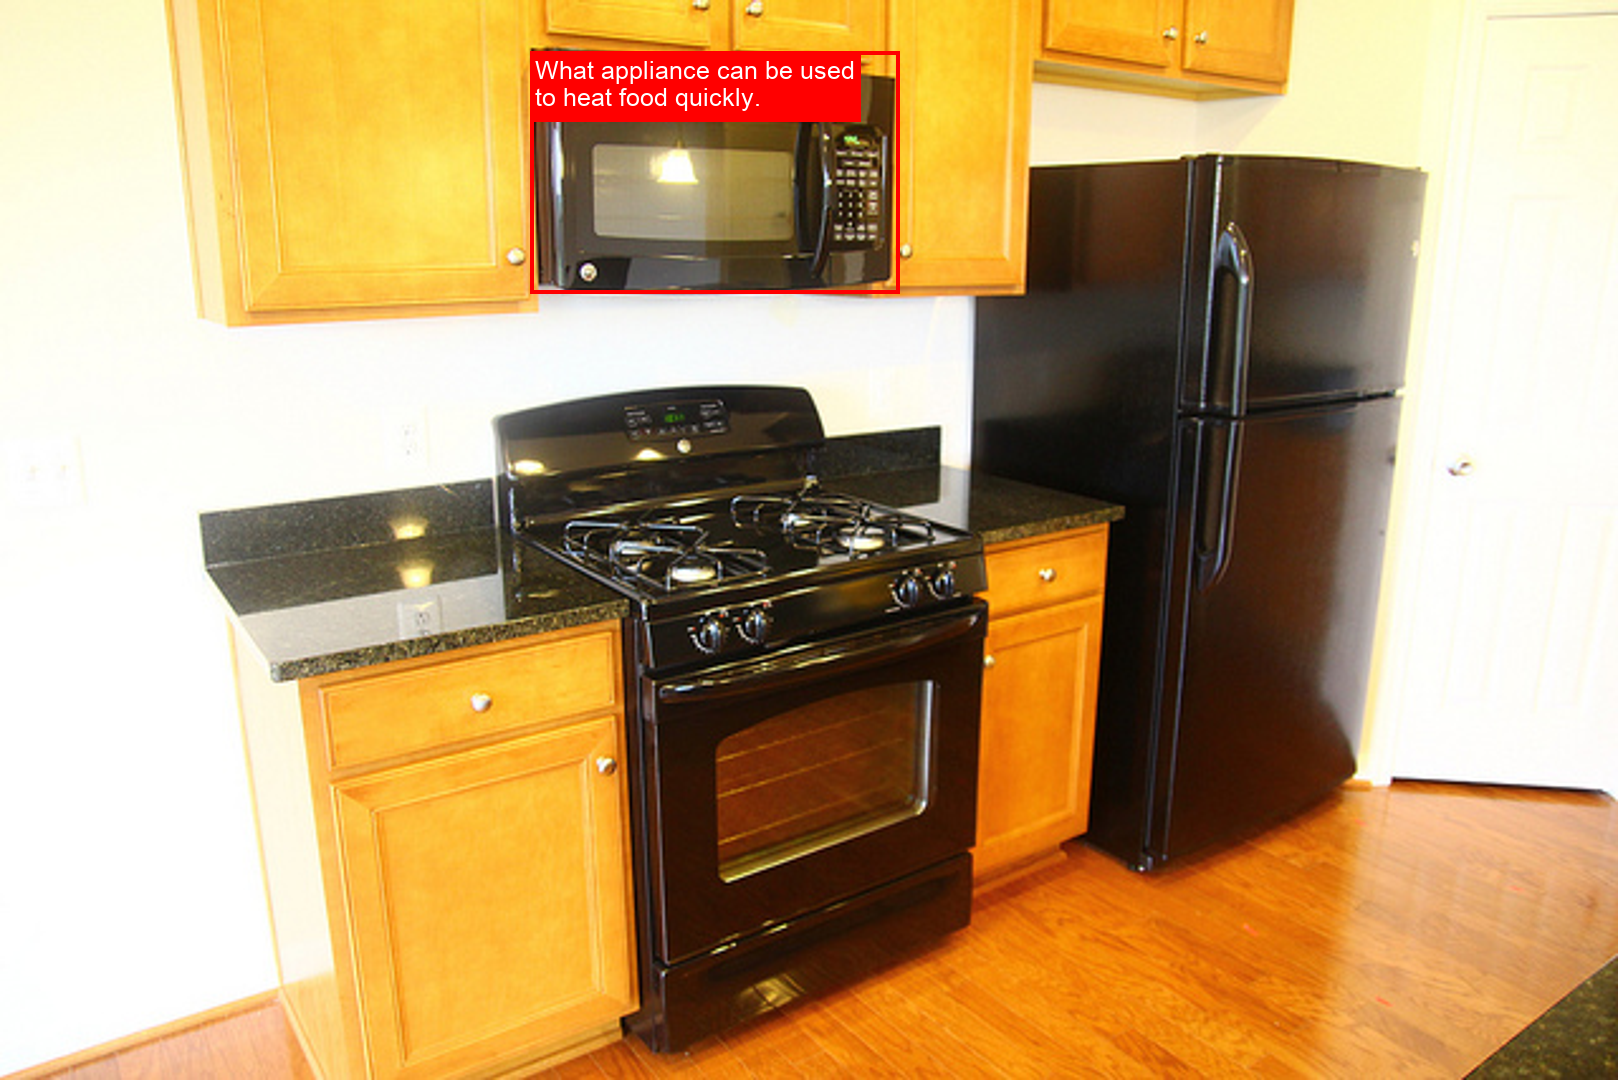

In [10]:
bbox = parse_bbox(output_text)
image = Image.open(image_path).convert("RGB")
image = image.resize((int(1080*image.size[0]/image.size[1]),1080))
w, h = image.size
bbox_raw = convert_bbox_to_raw(bbox, w, h)

draw_bbox_on_image(image, bbox_raw, color="red", width=4, show_width=600, text=instruction)